# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import tensor
from torch import optim
from torchvision import datasets,transforms
import PIL
from collections import OrderedDict
import argparse
from PIL import Image
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import json
%matplotlib inline


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(size=224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                ]),
    'valid':transforms.Compose([transforms.RandomResizedCrop(size=256),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                ]),
    'test':transforms.Compose([transforms.RandomResizedCrop(size=256),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                ]),
}
    

# TODO: Load the datasets with ImageFolder
image_datasets = { 'train': datasets.ImageFolder(train_dir,transform = data_transforms['train']),
                 'valid': datasets.ImageFolder(valid_dir,transform = data_transforms['valid']),
                 'test': datasets.ImageFolder(test_dir,transform = data_transforms['test'])
                 } 
# TODO: Using the image datasets and the trainforms, define the dataloaders
data_loader = {'train':torch.utils.data.DataLoader(image_datasets['train'],batch_size = 64,shuffle=True),
              'valid':torch.utils.data.DataLoader(image_datasets['valid'],batch_size = 64,shuffle=True),
              'test':torch.utils.data.DataLoader(image_datasets['test'],batch_size = 64,shuffle=True)
              }



### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [10]:
# TODO: Build and train your network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg19(pretrained = True)

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(25088,4096)),
    ('relu1',nn.ReLU()),
    ('dropout1',nn.Dropout(p=0.5)),
    ('fc2',nn.Linear(4096,1024)),
    ('relu2',nn.ReLU()),
    ('dropout2',nn.Dropout(p=0.5)),
    ('fc3',nn.Linear(1024,102)),
    ('output',nn.LogSoftmax(dim=1))
]))
model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# TODO: Do validation on the test set
epochs = 15


for e in range (epochs):
    print("Epoch: {}/{}".format(e+1,epochs))
    model.train()
    running_loss=0.0
    
    
    for i, (inputs,labels) in enumerate(data_loader['train']):
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        output=model.forward(inputs)
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss +=loss.item() * inputs.size(0)
        print("Train Loss: {:.4f}".format(loss.item()))
    
    valid_loss = 0.0
    valid_accuracy =0.0
    with torch.no_grad():
        model.eval()
        
        for ii,(inputs,labels) in enumerate(data_loader['valid']):
            optimizer.zero_grad()
            inputs,labels = inputs.to(device),labels.to(device)
            output=model.forward(inputs)
            loss=criterion(output,labels)
            valid_loss += loss.item() * inputs.size(0)
            
            ret,predictions = torch.max(output.data,1)
            equality = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(equality.type(torch.FloatTensor))
            valid_accuracy += acc.item() * inputs.size(0)
            print("validation loss:{:.4f}".format(loss.item()),
                    "Accuracy: {:.4f}".format(acc.item()))
            
            
    
    

Epoch: 1/15
Train Loss: 1.4770
Train Loss: 1.2949
Train Loss: 1.1023
Train Loss: 1.2220
Train Loss: 1.8599
Train Loss: 1.1342
Train Loss: 1.3303
Train Loss: 1.4967
Train Loss: 1.4109
Train Loss: 1.2387
Train Loss: 1.6159
Train Loss: 1.9566
Train Loss: 1.4340
Train Loss: 2.1979
Train Loss: 1.6961
Train Loss: 1.2628
Train Loss: 1.5557
Train Loss: 1.9846
Train Loss: 0.9852
Train Loss: 0.9561
Train Loss: 0.8238
Train Loss: 1.3287
Train Loss: 1.2283
Train Loss: 1.4628
Train Loss: 1.1908
Train Loss: 1.1808
Train Loss: 1.4493
Train Loss: 1.4193
Train Loss: 1.5545
Train Loss: 1.5516
Train Loss: 1.4541
Train Loss: 1.1964
Train Loss: 1.2255
Train Loss: 1.7042
Train Loss: 1.6439
Train Loss: 1.6495
Train Loss: 1.1451
Train Loss: 1.8027
Train Loss: 1.3809
Train Loss: 1.7404
Train Loss: 1.2137
Train Loss: 1.0806
Train Loss: 1.8331
Train Loss: 1.6285
Train Loss: 1.4542
Train Loss: 1.1804
Train Loss: 1.3004
Train Loss: 1.0645
Train Loss: 1.5252
Train Loss: 1.8007
Train Loss: 1.1467
Train Loss: 1.0169


Train Loss: 1.2446
Train Loss: 1.2254
Train Loss: 1.8281
Train Loss: 1.0897
Train Loss: 1.1567
Train Loss: 1.4095
Train Loss: 1.5460
Train Loss: 1.2364
Train Loss: 1.6776
Train Loss: 1.2191
Train Loss: 1.3822
Train Loss: 1.5364
Train Loss: 0.9271
Train Loss: 1.2920
Train Loss: 1.2162
Train Loss: 1.2260
Train Loss: 1.1133
Train Loss: 1.3059
Train Loss: 1.6219
Train Loss: 1.1474
Train Loss: 1.1874
Train Loss: 1.6902
Train Loss: 1.7009
Train Loss: 1.2311
Train Loss: 1.5788
Train Loss: 1.2100
Train Loss: 0.9998
Train Loss: 1.3382
Train Loss: 0.8699
Train Loss: 1.6140
Train Loss: 1.0776
Train Loss: 1.3039
Train Loss: 1.3737
Train Loss: 1.1914
Train Loss: 1.3827
Train Loss: 1.5277
Train Loss: 1.1417
Train Loss: 1.5651
Train Loss: 1.1716
Train Loss: 1.0561
Train Loss: 1.3897
Train Loss: 1.4396
Train Loss: 1.3737
Train Loss: 1.8334
Train Loss: 1.2927
Train Loss: 1.1979
Train Loss: 1.8226
Train Loss: 0.9635
Train Loss: 1.5020
Train Loss: 1.5798
Train Loss: 1.1738
Train Loss: 1.6589
Train Loss: 

Train Loss: 1.3289
Train Loss: 1.2965
Train Loss: 0.6390
Train Loss: 1.1052
Train Loss: 0.9436
Train Loss: 1.0964
Train Loss: 1.0319
Train Loss: 1.1064
Train Loss: 1.6563
Train Loss: 1.2447
Train Loss: 0.9437
Train Loss: 1.3563
Train Loss: 0.8583
Train Loss: 1.6731
Train Loss: 1.0789
Train Loss: 1.4614
Train Loss: 1.3220
Train Loss: 1.5629
Train Loss: 2.1887
Train Loss: 1.3908
Train Loss: 1.3876
Train Loss: 0.8861
Train Loss: 1.5276
Train Loss: 1.0970
Train Loss: 0.9962
Train Loss: 0.8748
validation loss:0.9790 Accuracy: 0.7344
validation loss:1.0882 Accuracy: 0.7656
validation loss:0.7313 Accuracy: 0.8281
validation loss:0.8279 Accuracy: 0.8281
validation loss:1.2706 Accuracy: 0.6719
validation loss:0.9783 Accuracy: 0.8125
validation loss:1.1552 Accuracy: 0.7031
validation loss:0.7761 Accuracy: 0.7969
validation loss:1.1477 Accuracy: 0.7031
validation loss:1.0209 Accuracy: 0.7656
validation loss:1.0953 Accuracy: 0.7344
validation loss:0.7413 Accuracy: 0.7969
validation loss:0.8768 Acc

validation loss:1.1128 Accuracy: 0.7812
validation loss:0.8597 Accuracy: 0.7812
validation loss:1.1022 Accuracy: 0.7031
validation loss:0.9467 Accuracy: 0.7344
validation loss:0.5246 Accuracy: 0.8594
validation loss:1.0215 Accuracy: 0.7656
validation loss:0.8688 Accuracy: 0.7800
Epoch: 11/15
Train Loss: 1.1773
Train Loss: 1.2488
Train Loss: 0.9202
Train Loss: 1.2791
Train Loss: 1.7428
Train Loss: 1.3801
Train Loss: 1.4395
Train Loss: 1.6580
Train Loss: 1.3282
Train Loss: 1.0595
Train Loss: 1.8329
Train Loss: 1.8450
Train Loss: 1.4403
Train Loss: 1.5465
Train Loss: 0.9287
Train Loss: 0.9724
Train Loss: 1.3694
Train Loss: 1.5692
Train Loss: 1.1938
Train Loss: 1.4229
Train Loss: 0.8152
Train Loss: 1.0902
Train Loss: 1.1868
Train Loss: 1.3227
Train Loss: 1.3498
Train Loss: 1.4176
Train Loss: 1.1270
Train Loss: 0.9975
Train Loss: 1.3625
Train Loss: 1.2713
Train Loss: 1.1927
Train Loss: 1.0394
Train Loss: 1.4199
Train Loss: 1.3131
Train Loss: 1.4220
Train Loss: 1.1999
Train Loss: 0.9636
Trai

Train Loss: 1.6195
Train Loss: 1.0078
Train Loss: 1.1105
Train Loss: 1.0878
Train Loss: 1.2916
Train Loss: 1.0997
Train Loss: 1.6612
Train Loss: 0.8471
Train Loss: 0.9175
Train Loss: 1.0570
Train Loss: 1.1185
Train Loss: 1.3663
Train Loss: 1.4269
Train Loss: 1.1453
Train Loss: 1.2000
Train Loss: 1.5103
Train Loss: 0.8347
Train Loss: 1.0618
Train Loss: 1.3398
Train Loss: 0.9403
Train Loss: 0.7016
Train Loss: 0.9484
Train Loss: 1.4921
Train Loss: 0.9984
Train Loss: 1.7967
Train Loss: 1.2526
Train Loss: 1.6241
Train Loss: 1.3422
Train Loss: 0.7661
Train Loss: 1.0762
Train Loss: 1.2622
Train Loss: 1.5790
Train Loss: 1.6248
Train Loss: 1.0433
Train Loss: 1.1350
Train Loss: 1.4768
Train Loss: 1.1013
Train Loss: 1.6107
Train Loss: 1.0904
Train Loss: 1.0733
Train Loss: 1.3347
Train Loss: 1.6719
Train Loss: 1.2714
Train Loss: 1.1615
Train Loss: 1.3004
Train Loss: 0.9916
Train Loss: 1.0318
Train Loss: 0.9487
Train Loss: 1.4344
Train Loss: 1.8431
Train Loss: 0.8506
Train Loss: 1.4918
Train Loss: 

In [14]:
total = 0.0
accr = 0.0
with torch.no_grad():
        model.eval()
        
        for iii,(inputs,labels) in enumerate(data_loader['test']):
            optimizer.zero_grad()
            inputs,labels = inputs.to(device),labels.to(device)
            output=model.forward(inputs)
            ret,predictions = torch.max(output.data,1)
            total += labels.size(0)
            accr += (predictions == labels).sum().item() 
            
print("Accuracy of the model %d%%" % (100*accr/total))
            
            

Accuracy of the model 77%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'structure':'vgg19',
             'class_to_idx':model.class_to_idx,
             'layers':[25088,4096,1024,102],
             'dropout': '0.5',
             'epochs': 5,
             'state_dict':model.state_dict,
             'optimizer_state_dict': optimizer.state_dict()
             }

torch.save(checkpoint,'model_checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def loading_checkpoint(path='checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth')
    model = model.vgg19(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.class_to_idx = checkpoint[class_to_idx]
    model.load_state_dict(checkpoint['state_dict'])
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
    
    process_image = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                ])
    np_image = process_image(pil_image)
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

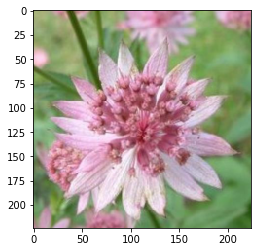

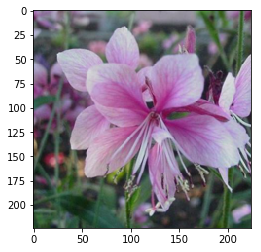

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
imshow(process_image("flowers/test/38/image_05812.jpg"))
imshow(process_image("flowers/test/57/image_08144.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    image = process_image(image_path).to(device)
    np_image = image.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(np_image)
    ps = torch.exp(output)
    k_top,top_classes_idx = ps.topk(topk,dim=1)
    k_top,top_classes_idx = np.array(k_top.to('cpu')[0]),np.array(top_classes_idx.to('cpu')[0])
    
    idx_to_class = {x:y for y,x in model.class_to_idx.items()}
    top_classes = []
    for index in top_classes_idx:
        top_classes.append(idx_to_class[index])
        
        
    return list(k_top), list(top_classes)

predict('flowers/test/15/image_06360.jpg',model)

([0.98605525, 0.013499427, 9.4806841e-05, 8.4537292e-05, 8.3486768e-05],
 ['15', '42', '48', '90', '83'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

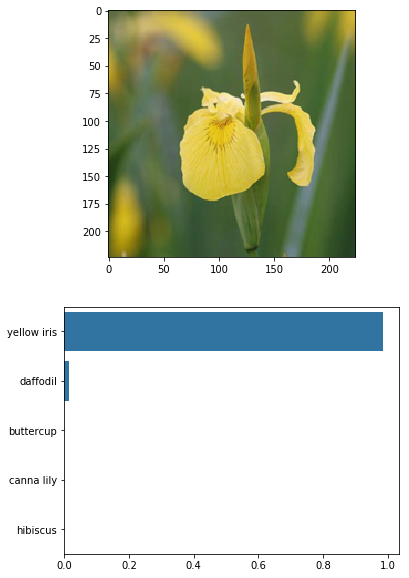

In [20]:
# TODO: Display an image along with the top 5 classes
image_path ='flowers/test/15/image_06360.jpg' 
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)
flower_numb = image_path.split('/')[2]
title_ = cat_to_name[flower_numb]
img = process_image(image_path)
imshow(img,ax,title=title_);
probs,classes = predict(image_path,model)
classes_names = [cat_to_name[number] for number in classes]


plt.subplot(2,1,2)
sns.barplot(x=probs,y=classes_names,color=sns.color_palette()[0]);
plt.show()

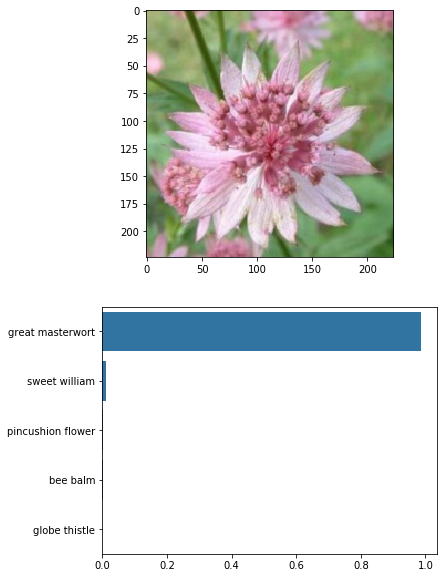

In [65]:
image_path ="flowers/test/38/image_05812.jpg"
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)
flower_numb = image_path.split('/')[2]
title_ = cat_to_name[flower_numb]
img = process_image(image_path)
imshow(img,ax,title=title_);
probs,classes = predict(image_path,model)
classes_names = [cat_to_name[number] for number in classes]


plt.subplot(2,1,2)
sns.barplot(x=probs,y=classes_names,color=sns.color_palette()[0]);
plt.show()

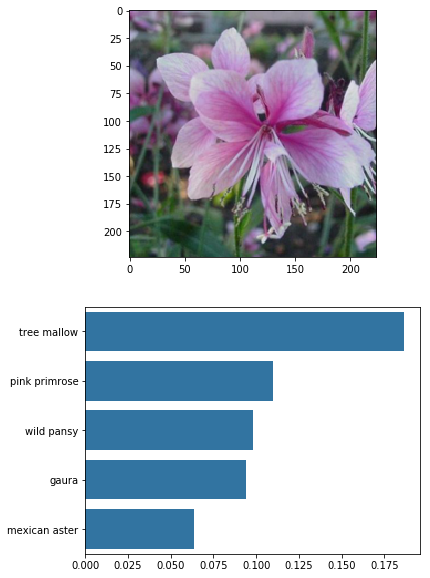

In [21]:
image_path ="flowers/test/57/image_08144.jpg"
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)
flower_numb = image_path.split('/')[2]
title_ = cat_to_name[flower_numb]
img = process_image(image_path)
imshow(img,ax,title=title_);
probs,classes = predict(image_path,model)
classes_names = [cat_to_name[number] for number in classes]


plt.subplot(2,1,2)
sns.barplot(x=probs,y=classes_names,color=sns.color_palette()[0]);
plt.show()